In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats
import re
import graphlab as gl
from graphlab.toolkits.feature_engineering import TFIDF, FeatureHasher, QuadraticFeatures

gl.canvas.set_target('ipynb')

PATH_TO_JSON2 = "/mnt/sframe/docs_prod_02/"
PATH_TO_JSON = "/mnt/sframe/docs_prod_05/"
PATH_TO_JSON6 = "/mnt/sframe/docs_prod_06/"
PATH_TO_JSON7 = "/mnt/sframe/docs_prod_07/"
PATH_TO_TRAIN_LABELS = "input/train.csv"
PATH_TO_TEST_LABELS = "input/sampleSubmission.csv"

### Read processed documents

In [2]:
gl.set_runtime_config('GRAPHLAB_DEFAULT_NUM_PYLAMBDA_WORKERS', 128)
gl.set_runtime_config('GRAPHLAB_FILEIO_MAXIMUM_CACHE_CAPACITY', 100*1024*1024*1024) # 100GB
gl.set_runtime_config('GRAPHLAB_FILEIO_MAXIMUM_CACHE_CAPACITY_PER_FILE', 100*1024*1024*1024) # 100GB

[INFO] This trial license of GraphLab Create is assigned to renatbek@gmail.com and will expire on October 08, 2015. Please contact trial@dato.com for licensing options or to request a free non-commercial license for personal or academic use.

[INFO] Start server at: ipc:///tmp/graphlab_server-14882 - Server binary: /usr/local/lib/python2.7/site-packages/graphlab/unity_server - Server log: /tmp/graphlab_server_1444124693.log
[INFO] GraphLab Server Version: 1.6.1


In [3]:
def transf(x):
    return x
    #return 50.0 * np.log1p(np.log1p(x))

In [4]:
# documents
sf = gl.SFrame.read_csv(PATH_TO_JSON, header=False, verbose=False)
sf = sf.unpack('X1',column_name_prefix='')
sf['id'] = sf['id'].apply(lambda x: str(x.split('_')[0] ))
sf['num_words'] = sf['text'].apply(lambda xs: transf(len(xs)))

In [5]:
sf2 = gl.SFrame.read_csv(PATH_TO_JSON2, header=False, verbose=False)
sf2 = sf2.unpack('X1',column_name_prefix='')
sf2['id'] = sf2['id'].apply(lambda x: str(x.split('_')[0] ))

In [6]:
sf6 = gl.SFrame.read_csv(PATH_TO_JSON6, header=False, verbose=False)
sf6 = sf6.unpack('X1',column_name_prefix='')
sf6['id'] = sf6['id'].apply(lambda x: str(x.split('_')[0] ))
sf6['word2vec'] = sf6['word2vec'].apply(lambda xs: np.array(xs ,dtype='float32').tolist())

In [7]:
sf7 = gl.SFrame.read_csv(PATH_TO_JSON7, header=False, verbose=False)
sf7 = sf7.unpack('X1',column_name_prefix='')
sf7['id'] = sf7['id'].apply(lambda x: str(x.split('_')[0] ))


In [8]:
sf7.head()

basic,fb_id,ga_cnt,ga_id,ga_len,ga_line,ga_subid,id
"[0, 0, 0, 0, 0, 0]",0,0,2762424,48,15,1,428534
"[0, 0, 0, 0, 0, 1]",0,1,142218,60,927,29,428548
"[0, 1, 0, 0, 0, 0]",0,0,3535636,41,134,6,428551
"[0, 0, 1, 0, 0, 1]",0,0,0,1000,5000,0,428556
"[0, 0, 1, 1, 0, 0]",0,0,216712,44,87,3,428557
"[0, 1, 1, 1, 0, 1]",0,0,435387,39,746,1,428571
"[0, 0, 0, 0, 0, 0]",348371495273904,0,45201595,44,161,1,428584
"[0, 0, 0, 0, 0, 1]",0,0,92124,50,22,1,428594
"[0, 1, 0, 0, 0, 0]",0,0,6671908,54,1145,2,428601
"[0, 0, 0, 0, 0, 0]",0,0,0,1000,5000,0,428604


In [9]:
sf_cnt = gl.SFrame()
sf_cnt['id'] = sf2['id']

sf_cnt['a_href'] = sf2['ahref'].apply(lambda x: transf(len(x)))
sf_cnt['par'] = sf2['par'].apply(lambda x: transf(len(x)))
sf_cnt['title'] = sf2['title'].apply(lambda x: transf(len(x)))

sf_cnt['img'] = sf2['img_cnt'].apply(transf)
sf_cnt['btn'] = sf2['misc_button'].apply(transf)
sf_cnt['input'] = sf2['misc_input'].apply(transf)
sf_cnt['li'] = sf2['misc_li'].apply(transf)
sf_cnt['link'] = sf2['misc_link'].apply(transf)
sf_cnt['meta'] = sf2['misc_meta'].apply(transf)

sf_cnt['script_avg'] = sf2['script_avg'].apply(transf)
sf_cnt['script_b_avg'] = sf2['script_b_avg'].apply(transf)
sf_cnt['script_cnt'] = sf2['script_cnt'].apply(transf)
sf_cnt['script_b_cnt'] = sf2['script_b_cnt'].apply(transf)

sf_cnt['style_avg'] = sf2['style_avg'].apply(transf)
sf_cnt['style_cnt'] = sf2['style_cnt'].apply(transf)

### Read train/test labels and merge into documents

In [10]:
# train/test labels
train_labels = gl.SFrame.read_csv(PATH_TO_TRAIN_LABELS, verbose=False)
test_labels = gl.SFrame.read_csv(PATH_TO_TEST_LABELS, verbose=False)
train_labels['id'] = train_labels['file'].apply(lambda x: str(x.split('_')[0] ))
train_labels = train_labels.remove_column('file')
test_labels['id'] = test_labels['file'].apply(lambda x: str(x.split('_')[0] ))
test_labels = test_labels.remove_column('file')

In [11]:
# join
train = train_labels.join(sf, on='id', how='left')
test = test_labels.join(sf, on='id', how='left')

In [12]:
train = train.join(sf_cnt, on='id', how='left')
test = test.join(sf_cnt, on='id', how='left')

In [13]:
train = train.join(sf6, on='id', how='left')
test = test.join(sf6, on='id', how='left')

In [14]:
train = train.join(sf7, on='id', how='left')
test = test.join(sf7, on='id', how='left')

In [15]:
f = 'ga_len'
train = train.fillna(f, 1000)     
test = test.fillna(f, 1000)
f = 'ga_line'
train = train.fillna(f, 5000)     
test = test.fillna(f, 5000)
f = 'basic'
train = train.fillna(f, [0,0,0,0,0,0])     
test = test.fillna(f, [0,0,0,0,0,0])

In [16]:
features = [
            'a_href',
            'par',
            'title',
            'img',
            'btn',
            'input',
            'li',
            'link',
            'meta',
            'script_avg',
            'script_b_avg',
            'script_cnt',
            'script_b_cnt',
            'style_avg',
            'style_cnt',
            'num_words',
            'fb_id', # new features GA FB WP
            'ga_id',
            'ga_subid',
            'ga_cnt',
            'ga_len',
            'ga_line',
           ]

In [17]:
for f in features:
    train = train.fillna(f, 0.0)     
    test = test.fillna(f, 0.0)

In [78]:
train['ga_id'] = train['ga_id'].apply(float)
test['ga_id'] = test['ga_id'].apply(float)

train['ga_subid'] = train['ga_subid'].apply(float)
test['ga_subid'] = test['ga_subid'].apply(float)

train['fb_id'] = train['fb_id'].apply(float)
test['fb_id'] = test['fb_id'].apply(float)

In [18]:
features = features + ['basic']

In [19]:
train = train.fillna('shinn', {})     
test = test.fillna('shinn', {})

train['shinn'] = train['shinn'].apply(lambda ws: ws if ws else {})
test['shinn'] = test['shinn'].apply(lambda ws: ws if ws else {})

features = features + ['shinn']

In [20]:
train = train.fillna('word2vec', np.zeros(300))     
test = test.fillna('word2vec', np.zeros(300))

train['word2vec'] = train['word2vec'].apply(lambda ws: ws if ws else np.zeros(300))
test['word2vec'] = test['word2vec'].apply(lambda ws: ws if ws else np.zeros(300))

In [21]:
train = train.fillna('words', [])     
test = test.fillna('words', [])   

train['words'] = train['words'].apply(lambda ws: ws if ws else [])
test['words'] = test['words'].apply(lambda ws: ws if ws else [])

In [22]:
train['word_set_size'] = train['words'].apply(lambda ws: len(set(ws)))
test['word_set_size'] = test['words'].apply(lambda ws: len(set(ws)))

train['word_set_size_ratio'] = train.apply(lambda r: r['word_set_size'] * 1.0 / len(r['words']) if len(r['words']) > 0 else 0.0)
test['word_set_size_ratio'] = test.apply(lambda r: r['word_set_size'] * 1.0 / len(r['words']) if len(r['words']) > 0 else 0.0)

In [23]:
train['text_words'] = train['words'].apply(lambda ws: ' '.join(ws))
test['text_words'] = test['words'].apply(lambda ws: ' '.join(ws))

In [24]:
features = features + ['word_set_size', 'word_set_size_ratio']

In [25]:
def text2wordsetsize(text):
    if not text:
        return 0.0
    else:
        return len(set(text.split()))
    
def safe_divide(a, b):
    if b > 0:
        return a * 1.0 / b
    else:
        return 0.0

train['word_set_size2'] = train['text'].apply(text2wordsetsize)
test['word_set_size2'] = test['text'].apply(text2wordsetsize)

train['word_set_size2_ratio'] = train.apply(lambda r: safe_divide(r['word_set_size2'], r['word_set_size']))
test['word_set_size2_ratio'] = test.apply(lambda r: safe_divide(r['word_set_size2'], r['word_set_size']))

features = features + ['word_set_size2', 'word_set_size_ratio2']

In [33]:
train.head()

sponsored,id,text,num_words,a_href,par,title,img,btn,input,li,link
0,920982,bill gate world richestmost time beaten norweg ...,2670,56,9,44,4,0,4,30,13
0,920988,credit netflix fandomleah tedesco follow ...,6671,183,20,31,13,0,12,150,10
0,920992,bimota microsoftfrontpag frontpag editor ...,52,0,0,12,0,0,0,0,0
0,921036,make your reflect yourpoint across with thi ...,6962,227,1,73,23,13,15,81,30
0,921040,play music suppos remembsometim electron ...,5177,110,22,67,44,0,3,68,5
0,921050,ecogrid ecorast ecogridecorast ecogrid ecorast ...,2012,74,16,75,12,0,0,15,8
0,921108,topic sunday polic chargyear jeffrey william ...,7318,70,38,68,13,4,13,24,11
1,921123,celebr your passion hobbiwith great video more ...,3566,19,21,60,5,0,0,26,23
1,921127,local queri searchlanguag countri welcom ...,260,6,0,44,0,0,2,0,4
0,921130,they necess mother inventwhat they neglect men ...,12831,210,26,65,37,1,10,158,19


In [27]:
#train.save('/mnt/sframe/sframe_train')
#test.save('/mnt/sframe/sframe_test')

In [30]:
train.remove_column('text_words')
test.remove_column('text_words')
train.remove_column('words')
test.remove_column('words')
train.remove_column('word2vec')
test.remove_column('word2vec')

KeyError: 'Cannot find column words'

In [50]:
train = train.unpack('shinn')
test = test.unpack('shinn')

train = train.unpack('basic')
test = test.unpack('basic')

In [34]:
df_train = train.to_dataframe()
df_test = test.to_dataframe()

df_train.to_pickle('/mnt/sframe/df_train')
df_test.to_pickle('/mnt/sframe/df_test')

In [54]:
train = train.pack_columns(column_prefix='shinn', dtype=dict, new_column_name='shinn')
test = test.pack_columns(column_prefix='shinn', dtype=dict, new_column_name='shinn')

train = train.pack_columns(column_prefix='basic', dtype=dict, new_column_name='basic')
test = test.pack_columns(column_prefix='basic', dtype=dict, new_column_name='basic')

### Generate BOW

In [38]:
bow_trn = gl.text_analytics.count_words(train['text'])
bow_trn = bow_trn.dict_trim_by_keys(gl.text_analytics.stopwords())

bow_tst = gl.text_analytics.count_words(test['text'])
bow_tst = bow_tst.dict_trim_by_keys(gl.text_analytics.stopwords())

train['bow'] = bow_trn
test['bow'] = bow_tst

### Generate TF-IDF

In [39]:
encoder = gl.feature_engineering.create(train, TFIDF('bow', output_column_name='tfidf', min_document_frequency=5e-5))
train = encoder.transform(train)
test = encoder.transform(test)

In [40]:
train['tfidf'] = train['tfidf'].fillna({})
test['tfidf'] = test['tfidf'].fillna({})

train['tfidf'] = train['tfidf'].apply(lambda x: x if x else {})
test['tfidf'] = test['tfidf'].apply(lambda x: x if x else {})

## Features

In [41]:
def feature_col(col):
    return col not in set(['sponsored', 'id', 'text', 'text_words', 'word2vec', 'words', 'bow'])

features = [f for f in train.column_names() if feature_col(f)]

### Split training set for cross-validation

In [55]:
train_train, train_cv = train.random_split(0.80, seed=107)

In [56]:
train_train_train, train_train_cv = train_train.random_split(0.75, seed=7)

In [57]:
TRAIN, CV = train_train_cv.random_split(0.50, seed=113)

In [58]:
TRAIN.shape, CV.shape

((33848, 33), (33660, 33))

In [46]:
features

['num_words',
 'a_href',
 'par',
 'title',
 'img',
 'btn',
 'input',
 'li',
 'link',
 'meta',
 'script_avg',
 'script_b_avg',
 'script_cnt',
 'script_b_cnt',
 'style_avg',
 'style_cnt',
 'fb_id',
 'ga_cnt',
 'ga_id',
 'ga_len',
 'ga_line',
 'ga_subid',
 'word_set_size',
 'word_set_size_ratio',
 'word_set_size2',
 'word_set_size2_ratio',
 'shinn',
 'basic',
 'tfidf']

# Generate Submission Model

Started at 06:35:00am

In [ ]:
model = gl.classifier.boosted_trees_classifier.create(train, target='sponsored',
                                                      #features=features + ['tfidf_hashed_18'],
                                                      features=features + ['tfidf5e5'],
                                                      max_depth=6,
                                                      step_size=0.2,
                                                      max_iterations=300,
                                                      column_subsample=0.3,
                                                      row_subsample=1.0,
                                                      class_weights='auto')

In [ ]:
model = gl.classifier.random_forest_classifier.create(train, target='sponsored',
                                                      features=features, # + ['tfidf', 'word2vec'],
                                                      num_trees=600,
                                                      max_depth=150,
                                                      validation_set=None,
                                                      column_subsample=0.3,
                                                      row_subsample=0.85,
                                                      class_weights='auto')

PROGRESS: WARNING: Detected extremely low variance for feature(s) 'basic' because all entries are nearly the same.
Proceeding with model training using all features. If the model does not provide results of adequate quality, exclude the above mentioned feature(s) from the input dataset.
PROGRESS: Random forest classifier:
PROGRESS: --------------------------------------------------------
PROGRESS: Number of examples          : 337024
PROGRESS: Number of classes           : 2
PROGRESS: Number of feature columns   : 29
PROGRESS: Number of unpacked features : 121825
PROGRESS: Starting Boosted Trees
PROGRESS: --------------------------------------------------------
PROGRESS:   Iter    Accuracy Elapsed time
PROGRESS:      0   9.387e-01       76.80s
PROGRESS:      1   9.422e-01      145.94s
PROGRESS:      2   9.586e-01      219.05s
PROGRESS:      3   9.673e-01      272.01s
PROGRESS:      4   9.717e-01      280.97s
PROGRESS:      5   9.753e-01      289.99s
PROGRESS:      6   9.777e-01      29

In [ ]:
model = gl.classifier.boosted_trees_classifier.create(train, target='sponsored',
                                                      #features=features + ['tfidf_hashed_18'],
                                                      features=features + ['tfidf'],
                                                      max_depth=6,
                                                      step_size=0.2,
                                                      max_iterations=300,
                                                      column_subsample=0.3,
                                                      row_subsample=1.0,
                                                      class_weights='auto',
                                                      validation_set=None)

In [ ]:
lr_model = gl.logistic_classifier.create(TRAIN_l, target='sponsored', 
                                      features=new_feats,
                                      validation_set=CV_l,
                                      class_weights='auto',
                                      max_iterations=10,
                                      l2_penalty=0.00,
                                      l1_penalty=0.00)

In [ ]:
svm_model = gl.svm_classifier.create(train, target='sponsored', 
                                      features=['tfidf_hashed'],
                                      validation_set=None,                                           
                                      class_weights='auto',
                                      max_iterations=20)

### Output model

In [ ]:
import datetime
print(datetime.datetime.now())

2015-10-06 15:44:04.702867


In [ ]:
ypred = model.predict(test, 'probability')

submission = gl.SFrame()
submission['file'] = test['id'].apply(lambda x: x + '_raw_html.txt')
submission['sponsored'] = ypred 
#submission.save('submission_version_4.csv', format='csv')

submission = submission.to_dataframe()
submission.to_csv('submission_rf_ga_2.csv', index=False, float_format='%1.8f')

In [ ]:
model.save('/mnt/sframe/model_RF_200_150_noword2vec')

In [ ]:
test

# Experiment

### Split train into *train_train*/*train_cv*

In [ ]:
model = gl.logistic_classifier.create(train_train, target='sponsored', 
                                      features=features + ['tfidf'],
                                      validation_set=train_cv,
                                      class_weights='auto',
                                      max_iterations=30,
                                      feature_rescaling=True,
                                      l2_penalty=0.00,
                                      l1_penalty=0.00)

In [ ]:
results = gl.SFrame()
results['id'] = train_cv['id']
results['actual'] = train_cv['sponsored']
results['predicted'] = model.predict(train_cv)

In [ ]:
train_cv.unpack('tfidf')

In [ ]:
FN.shape, FP.shape

In [ ]:
FN = results[results['actual'] > results['predicted']]
FP = results[results['actual'] < results['predicted']]

In [ ]:
FN[720:730]

In [ ]:
FP

In [ ]:
model.evaluate(train_cv)

In [ ]:
results = model.evaluate(train_cv, metric='roc_curve')
a = results['roc_curve']

fpr = list(a['fpr'])
tpr = list(a['tpr'])
fpr[0] = 1.0
tpr[0] = 1.0
fpr = np.array(fpr)
tpr = np.array(tpr)

AUC = np.sum((fpr[:-1] - fpr[1:]) * (tpr[:-1] + (tpr[:-1] - tpr[1:])/2))
plt.plot(fpr, tpr)
print('AUC = %f'%AUC)

In [ ]:
train_cv.remove_column('tfidf_hashed17')

In [ ]:
svm_model = gl.svm_classifier.create(train_train, target='sponsored', 
                                      features=features + ['tfidf_hashed'],
                                      validation_set=train_cv,                                           
                                      class_weights='auto',
                                      max_iterations=15)

In [ ]:
svm_model

In [ ]:
train_cv['margin'] = svm_model.predict(train_cv, output_type='margin')
preds = train_cv[['sponsored', 'margin']].sort('margin')
train_cv.remove_column('margin')

pd_preds = preds.to_dataframe()
pd_preds['number'] = 1.0

pd_preds_cum = pd_preds.cumsum()

total_positives = np.asarray(pd_preds_cum['sponsored'])[-1]
total = np.asarray(pd_preds_cum['number'])[-1]
total_negatives = total - total_positives

pd_preds_cum['FN'] = pd_preds_cum['sponsored']
pd_preds_cum['TN'] = pd_preds_cum['number'] - pd_preds_cum['sponsored']

pd_preds_cum['TP'] = total_positives - pd_preds_cum['FN']
pd_preds_cum['FP'] = total - total_positives - pd_preds_cum['TN']

pd_preds_cum['fpr'] = pd_preds_cum['FP'] / (pd_preds_cum['FP'] + pd_preds_cum['TN'])
pd_preds_cum['tpr'] = pd_preds_cum['TP'] / (pd_preds_cum['TP'] + pd_preds_cum['FN'])



In [ ]:
a = pd_preds_cum

fpr = list(a['fpr'])
tpr = list(a['tpr'])
fpr[0] = 1.0
tpr[0] = 1.0
fpr = np.array(fpr)
tpr = np.array(tpr)

AUC = np.sum((fpr[:-1] - fpr[1:]) * (tpr[:-1] + (tpr[:-1] - tpr[1:])/2))
plt.plot(fpr, tpr)
print('AUC = %f'%AUC)

In [ ]:
train_cv['margin'] = svm_model.predict(train_cv, output_type='margin')
preds = train_cv[['sponsored', 'margin']]
preds['margin'].show()

In [ ]:
(preds[preds['margin'] < 55]['sponsored']).sum()

In [ ]:
ts = np.arange(-22, 50, 0.1)
[for t in ts]

In [ ]:
svm_model.evaluate(train_cv)

In [ ]:
results = svm_model.evaluate(train_cv, metric='roc_curve')
a = results['roc_curve']

fpr = list(a['fpr'])
tpr = list(a['tpr'])
fpr[0] = 1.0
tpr[0] = 1.0
fpr = np.array(fpr)
tpr = np.array(tpr)

AUC = np.sum((fpr[:-1] - fpr[1:]) * (tpr[:-1] + (tpr[:-1] - tpr[1:])/2))
plt.plot(fpr, tpr)
print('AUC = %f'%AUC)

In [ ]:
results

# Save Datasets?

In [ ]:
train.save('/mnt/sframe/plain_train')
test.save('/mnt/sframe/plain_test')

In [ ]:
train_train = gl.load_sframe('/mnt/sframe/shinn_split_train_train')
train_cv = gl.load_sframe('/mnt/sframe/shinn_split_train_cv')

In [ ]:
train_train.head()

# Junk

In [ ]:
model_17 = gl.logistic_classifier.create(train_train, target='sponsored', 
                                      features=['tfidf_hashed_17'],
                                      validation_set=train_cv,
                                      class_weights=None, #'auto',
                                      max_iterations=7,
                                      feature_rescaling=True,
                                      l2_penalty=0.00,
                                      l1_penalty=0.00)

In [ ]:
model_17.evaluate(train_cv)

In [ ]:
results = model_17.evaluate(train_cv, metric='roc_curve')
a = results['roc_curve']

fpr = list(a['fpr'])
tpr = list(a['tpr'])
fpr[0] = 1.0
tpr[0] = 1.0
fpr = np.array(fpr)
tpr = np.array(tpr)

AUC = np.sum((fpr[:-1] - fpr[1:]) * (tpr[:-1] + (tpr[:-1] - tpr[1:])/2))
plt.plot(fpr, tpr)
print('AUC = %f'%AUC)

In [ ]:
gl.svm_classifier.create(train_train, target='sponsored', 
                                      features=['tfidf_hashed_15'],
                                      validation_set=train_cv,                                           
                                      class_weights='auto',
                                      max_iterations=40)

# Continue with data

In [ ]:
train = gl.load_sframe('/mnt/sframe/counts_and_tfidf_hashed_18_train')
test = gl.load_sframe('/mnt/sframe/counts_and_tfidf_hashed_18_test')

train_train = gl.load_sframe('/mnt/sframe/num_words_counts_and_tfidf_hashed_18_split_train_train')
train_cv = gl.load_sframe('/mnt/sframe/num_words_counts_and_tfidf_hashed_18_split_train_cv')

TRAIN, CV = train_cv.random_split(0.50, seed=113)

In [ ]:
train.save('/mnt/sframe/shinn_train')
test.save('/mnt/sframe/shinn_test')

train_train.save('/mnt/sframe/shinn_split_train_train')
train_cv.save('/mnt/sframe/shinn_split_train_cv')
#train_train = gl.load_sframe('/mnt/sframe/tfidf_hashed_16_split_train_train')
#train_cv = gl.load_sframe('/mnt/sframe/tfidf_hashed_16_split_train_cv')

## Try classifiers

In [ ]:
def text2wordsetsize(text):
    if not text:
        return 0.0
    else:
        return len(set(text.split()))
    
def safe_divide(a, b):
    if b > 0:
        return a * 1.0 / b
    else:
        return 0.0

TRAIN['word_set_size2'] = TRAIN['text'].apply(text2wordsetsize)
CV['word_set_size2'] = CV['text'].apply(text2wordsetsize)

TRAIN['word_set_size2_ratio'] = TRAIN.apply(lambda r: safe_divide(r['word_set_size2'], r['word_set_size']))
CV['word_set_size2_ratio'] = CV.apply(lambda r: safe_divide(r['word_set_size2'], r['word_set_size']))

In [ ]:
TRAIN.head()

In [ ]:
model_boosted.get_feature_importanceature_importance()

In [ ]:
# model_rf = gl.classifier.random_forest_classifier.create(train_train, target='sponsored',
#                                                       features=features + ['word2vec'],
#                                                       num_trees=10,
#                                                       max_depth=200,
#                                                       column_subsample=0.15,
#                                                       row_subsample=1.0,
#                                                       class_weights='auto',
#                                                       validation_set=train_cv)
model_boosted = gl.classifier.boosted_trees_classifier.create(TRAIN, target='sponsored',
                                                      features=features + ['shinn', # 'word_set_size2', 
                                                                           #'word_set_size2_ratio',
                                                                           'tfidf'], #, 'word2vec'],
                                                      max_depth=2,
                                                      step_size=0.15,  #0.2
                                                      max_iterations=15,
                                                      column_subsample=0.4,
                                                      row_subsample=1.0,
                                                      class_weights='auto',
                                                      validation_set=CV)

In [ ]:
results = model_boosted.evaluate(CV, metric='roc_curve')
a = results['roc_curve']

fpr = list(a['fpr'])
tpr = list(a['tpr'])
fpr[0] = 1.0
tpr[0] = 1.0
fpr = np.array(fpr)
tpr = np.array(tpr)

AUC = np.sum((fpr[:-1] - fpr[1:]) * (tpr[:-1] + (tpr[:-1] - tpr[1:])/2))
plt.plot(fpr, tpr)
print('AUC = %f'%AUC)

In [ ]:
model_rf.get_feature_importance().print_rows(60)

In [48]:
TRAIN.head()

sponsored,id,text,num_words,a_href,par,title,img,btn,input,li,link
1,921123,celebr your passion hobbiwith great video more ...,3566,19,21,60,5,0,0,26,23
0,921279,occas thi piec publicunivers iowa press co ...,5072,36,40,84,7,0,0,1,0
0,921342,avail your languag reportentri thi imag belong ...,1807,162,19,44,27,2,9,85,6
0,92148,about artist,18,4,1,16,6,0,0,0,0
1,921505,hear ford mustang startvideo were worri that ...,3478,248,8,47,104,0,11,91,7
0,921542,explor histori spaceeffort that never ground ...,2592,96,6,70,16,2,8,89,7
0,921640,ant falar dilogoengraadssimo repar ...,14239,199,17,76,83,2,2,110,11
0,921703,window error encyclopedwindow error wikiped ...,8465,118,77,48,19,0,6,36,11
0,921798,bush senior with ladenbrother creat use yahoo ...,632,50,0,48,23,0,12,0,0
0,921840,seri shake photographcarli davidson use hight ...,4467,95,20,85,24,0,12,38,17


In [66]:
features

['num_words',
 'a_href',
 'par',
 'title',
 'img',
 'btn',
 'input',
 'li',
 'link',
 'meta',
 'script_avg',
 'script_b_avg',
 'script_cnt',
 'script_b_cnt',
 'style_avg',
 'style_cnt',
 'fb_id',
 'ga_cnt',
 'ga_id',
 'ga_len',
 'ga_line',
 'ga_subid',
 'word_set_size',
 'word_set_size_ratio',
 'word_set_size2',
 'word_set_size2_ratio',
 'shinn',
 'basic',
 'tfidf']

In [81]:
train_train['ga_id'] = train_train['ga_id'].apply(float)
train_cv['ga_id'] = train_cv['ga_id'].apply(float)

train_train['ga_subid'] = train_train['ga_subid'].apply(float)
train_cv['ga_subid'] = train_cv['ga_subid'].apply(float)

train_train['fb_id'] = train_train['fb_id'].apply(float)
train_cv['fb_id'] = train_cv['fb_id'].apply(float)

In [77]:
TRAIN['ga_id'] = TRAIN['ga_id'].apply(float)
CV['ga_id'] = CV['ga_id'].apply(float)

TRAIN['ga_subid'] = TRAIN['ga_subid'].apply(float)
CV['ga_subid'] = CV['ga_subid'].apply(float)

TRAIN['fb_id'] = TRAIN['fb_id'].apply(float)
CV['fb_id'] = CV['fb_id'].apply(float)

In [75]:
TRAIN.head()

sponsored,id,text,num_words,a_href,par,title,img,btn,input,li,link
1,921123,celebr your passion hobbiwith great video more ...,3566,19,21,60,5,0,0,26,23
0,921279,occas thi piec publicunivers iowa press co ...,5072,36,40,84,7,0,0,1,0
0,921342,avail your languag reportentri thi imag belong ...,1807,162,19,44,27,2,9,85,6
0,92148,about artist,18,4,1,16,6,0,0,0,0
1,921505,hear ford mustang startvideo were worri that ...,3478,248,8,47,104,0,11,91,7
0,921542,explor histori spaceeffort that never ground ...,2592,96,6,70,16,2,8,89,7
0,921640,ant falar dilogoengraadssimo repar ...,14239,199,17,76,83,2,2,110,11
0,921703,window error encyclopedwindow error wikiped ...,8465,118,77,48,19,0,6,36,11
0,921798,bush senior with ladenbrother creat use yahoo ...,632,50,0,48,23,0,12,0,0
0,921840,seri shake photographcarli davidson use hight ...,4467,95,20,85,24,0,12,38,17


In [76]:
TRAIN.dtype

<bound method SFrame.dtype of Columns:
	sponsored	int
	id	str
	text	str
	num_words	int
	a_href	int
	par	int
	title	int
	img	int
	btn	int
	input	int
	li	int
	link	int
	meta	int
	script_avg	float
	script_b_avg	float
	script_cnt	int
	script_b_cnt	int
	style_avg	float
	style_cnt	int
	fb_id	float
	ga_cnt	int
	ga_id	float
	ga_len	int
	ga_line	int
	ga_subid	str
	word_set_size	int
	word_set_size_ratio	float
	word_set_size2	int
	word_set_size2_ratio	float
	bow	dict
	tfidf	dict
	shinn	dict
	basic	dict

Rows: 33848

Data:
+-----------+--------+-------------------------------+-----------+--------+-----+
| sponsored |   id   |              text             | num_words | a_href | par |
+-----------+--------+-------------------------------+-----------+--------+-----+
|     1     | 921123 | celebr your passion hobbi ... |    3566   |   19   |  21 |
|     0     | 921279 | occas thi piec public univ... |    5072   |   36   |  40 |
|     0     | 921342 | avail your languag report ... |    1807   |  162  

In [99]:
model_rf.get_feature_importance().print_rows(100)

+----------------------+-------+
|       feature        | count |
+----------------------+-------+
|      num_words       | 21758 |
|        a_href        | 14370 |
|        title         | 12283 |
|         par          | 12262 |
|      script_avg      | 10981 |
|         meta         | 10448 |
|     script_b_avg     |  9911 |
|         img          |  9702 |
|      script_cnt      |  8835 |
|      shinn["1"]      |  8509 |
|        ga_id         |  8370 |
|          li          |  8297 |
|         link         |  8221 |
|    word_set_size2    |  7988 |
|      shinn["6"]      |  7553 |
|        input         |  7538 |
|     shinn["13"]      |  7445 |
| word_set_size2_ratio |  7163 |
|      shinn["0"]      |  7107 |
|     script_b_cnt     |  6952 |
|      shinn["7"]      |  6940 |
|       ga_line        |  6874 |
|     shinn["16"]      |  6491 |
|      style_avg       |  6487 |
|     shinn["14"]      |  6481 |
|    word_set_size     |  6054 |
| word_set_size_ratio  |  5257 |
|        g

In [89]:
model_rf.get_feature_importance().print_rows(40)

+----------------------+-------+
|       feature        | count |
+----------------------+-------+
|      num_words       |  6445 |
|        title         |  3847 |
|         img          |  3803 |
|        a_href        |  3749 |
|     script_b_avg     |  3723 |
|          li          |  3128 |
|         link         |  3090 |
|      shinn["7"]      |  2973 |
|      shinn["0"]      |  2739 |
|      shinn["6"]      |  2656 |
| word_set_size2_ratio |  2539 |
|     shinn["16"]      |  2522 |
|       ga_line        |  2521 |
|      shinn["1"]      |  2487 |
|      script_avg      |  2455 |
|    word_set_size2    |  2451 |
|         par          |  2312 |
|        input         |  2276 |
|         meta         |  2258 |
| word_set_size_ratio  |  2228 |
|      script_cnt      |  2073 |
|     shinn["14"]      |  2054 |
|      style_avg       |  1814 |
|    word_set_size     |  1736 |
|     shinn["13"]      |  1599 |
|         btn          |  1535 |
|     script_b_cnt     |  1437 |
|        g

In [69]:
model_rf.get_feature_importance().print_rows(40)

+----------------------+-------+
|       feature        | count |
+----------------------+-------+
|      num_words       |  4523 |
|        title         |  2460 |
|      script_avg      |  2299 |
|        a_href        |  2203 |
|         par          |  1866 |
|      shinn["6"]      |  1692 |
|          li          |  1683 |
|     script_b_avg     |  1670 |
|         link         |  1536 |
|        input         |  1433 |
|      shinn["0"]      |  1410 |
|         meta         |  1408 |
|      shinn["7"]      |  1386 |
|      shinn["1"]      |  1309 |
|      script_cnt      |  1309 |
|      style_avg       |  1293 |
|     shinn["13"]      |  1280 |
|    word_set_size2    |  1190 |
|         img          |  1165 |
|    word_set_size     |  1150 |
|       ga_line        |  1100 |
| word_set_size2_ratio |  1071 |
|     shinn["14"]      |  1053 |
|     shinn["16"]      |  964  |
| word_set_size_ratio  |  942  |
|     script_b_cnt     |  880  |
|     shinn["15"]      |  699  |
|        g

In [96]:
model_rf = gl.classifier.random_forest_classifier.create(train_train, target='sponsored',
                                                      features=features,
                                                      num_trees=100, 
                                                      max_depth=150,
                                                      column_subsample=0.45,
                                                      row_subsample=1.0,
                                                      class_weights='auto',
                                                      validation_set=train_cv)

PROGRESS: WARNING: Detected extremely low variance for feature(s) 'basic' because all entries are nearly the same.
Proceeding with model training using all features. If the model does not provide results of adequate quality, exclude the above mentioned feature(s) from the input dataset.
PROGRESS: Random forest classifier:
PROGRESS: --------------------------------------------------------
PROGRESS: Number of examples          : 269988
PROGRESS: Number of classes           : 2
PROGRESS: Number of feature columns   : 29
PROGRESS: Number of unpacked features : 121825
PROGRESS: Starting Boosted Trees
PROGRESS: --------------------------------------------------------
PROGRESS:   Iter      Accuracy          Elapsed time
PROGRESS:         (training) (validation)
PROGRESS:      0   9.766e-01   7.753e-01       69.78s
PROGRESS:      1   9.777e-01   8.094e-01      104.21s
PROGRESS:      2   9.807e-01   8.120e-01      113.50s
PROGRESS:      3   9.823e-01   8.214e-01      122.08s
PROGRESS:      4   

In [83]:
TRAIN.shape

(33848, 33)

AUC = 0.949485


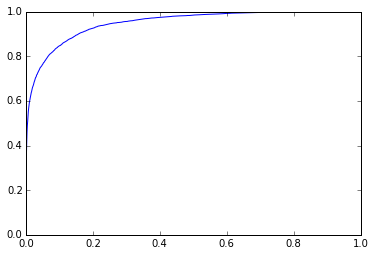

In [97]:
results = model_rf.evaluate(train_cv, metric='roc_curve')
a = results['roc_curve']

fpr = list(a['fpr'])
tpr = list(a['tpr'])
fpr[0] = 1.0
tpr[0] = 1.0
fpr = np.array(fpr)
tpr = np.array(tpr)

AUC = np.sum((fpr[:-1] - fpr[1:]) * (tpr[:-1] + (tpr[:-1] - tpr[1:])/2))
plt.plot(fpr, tpr)
print('AUC = %f'%AUC)

In [101]:
train_train.head()

sponsored,id,text,num_words,a_href,par,title,img,btn,input,li,link
0,920982,bill gate world richestmost time beaten norweg ...,2670,56,9,44,4,0,4,30,13
0,920992,bimota microsoftfrontpag frontpag editor ...,52,0,0,12,0,0,0,0,0
0,921036,make your reflect yourpoint across with thi ...,6962,227,1,73,23,13,15,81,30
0,921040,play music suppos remembsometim electron ...,5177,110,22,67,44,0,3,68,5
0,921050,ecogrid ecorast ecogridecorast ecogrid ecorast ...,2012,74,16,75,12,0,0,15,8
0,921108,topic sunday polic chargyear jeffrey william ...,7318,70,38,68,13,4,13,24,11
1,921123,celebr your passion hobbiwith great video more ...,3566,19,21,60,5,0,0,26,23
1,921127,local queri searchlanguag countri welcom ...,260,6,0,44,0,0,2,0,4
0,921130,they necess mother inventwhat they neglect men ...,12831,210,26,65,37,1,10,158,19
0,921133,come pearl ladi norenfound treasur shape p ...,952,14,6,42,21,0,0,0,4


In [ ]:
def generate_inverse(dataset, feats):
    new_feats = []
    for f in feats:
        new_feat = 'inv_' + f
        new_feats.append(new_feat)
        dataset[new_feat] = dataset.apply(lambda r: safe_divide(1, r[f]))
    return new_feats            

In [ ]:
features.remove('shinn')

In [ ]:
features

In [ ]:
new_feats = generate_inverse(TRAIN, features)
generate_inverse(CV, features)

In [ ]:
new_feats + features

quadratic = gl.feature_engineering.QuadraticFeatures(features=features + new_feats)
fit_quadratic = quadratic.fit(TRAIN)
TRAIN = fit_quadratic.transform(TRAIN)
CV = fit_quadratic.transform(CV)


In [ ]:
a = TRAIN.column_names()

In [ ]:
def for_inverse(col):
    return col not in set(['sponsored', 'id', 'text', 'text_words', 'words', 'bow', 'tfidf', 'shinn'])
[x for x in .column_names() if for_inverse(x)]

In [ ]:
TRAIN.remove_columns?

In [ ]:
T_TRAIN = TRAIN['word2vec'].unpack()
T_CV = CV['word2vec'].unpack()

T_TRAIN['sponsored'] = TRAIN['sponsored']
T_CV['sponsored'] = CV['sponsored']

In [ ]:
model_nn = gl.nearest_neighbor_classifier.create(TRAIN, target='sponsored', 
                                                 features=['tfidf'] # 'word2vec']
                                                )

In [ ]:
preds = model_nn.predict(CV, max_neighbors=200, output_type='probability')

In [ ]:
preds

In [ ]:
T_CV['prob'] = preds
preds = T_CV[['sponsored', 'prob']].sort('prob')
T_CV.remove_column('prob')

pd_preds = preds.to_dataframe()
pd_preds['number'] = 1.0

pd_preds_cum = pd_preds.cumsum()

total_positives = np.asarray(pd_preds_cum['sponsored'])[-1]
total = np.asarray(pd_preds_cum['number'])[-1]
total_negatives = total - total_positives

pd_preds_cum['FN'] = pd_preds_cum['sponsored']
pd_preds_cum['TN'] = pd_preds_cum['number'] - pd_preds_cum['sponsored']

pd_preds_cum['TP'] = total_positives - pd_preds_cum['FN']
pd_preds_cum['FP'] = total - total_positives - pd_preds_cum['TN']

pd_preds_cum['fpr'] = pd_preds_cum['FP'] / (pd_preds_cum['FP'] + pd_preds_cum['TN'])
pd_preds_cum['tpr'] = pd_preds_cum['TP'] / (pd_preds_cum['TP'] + pd_preds_cum['FN'])



In [ ]:
a = pd_preds_cum

fpr = list(a['fpr'])
tpr = list(a['tpr'])
fpr[0] = 1.0
tpr[0] = 1.0
fpr = np.array(fpr)
tpr = np.array(tpr)

AUC = np.sum((fpr[:-1] - fpr[1:]) * (tpr[:-1] + (tpr[:-1] - tpr[1:])/2))
plt.plot(fpr, tpr)
print('AUC = %f'%AUC)

In [ ]:
model1 = gl.classifier.random_forest_classifier.create(train_train, target='sponsored',
                                                      features=features + ['tfidf'], #, 'word2vec'],
                                                      num_trees=90, #100,
                                                      max_depth=150,
                                                      column_subsample=0.45,
                                                      row_subsample=1.0,
                                                      class_weights='auto',
                                                      validation_set=train_cv)

In [ ]:
results = model1.evaluate(train_cv, metric='roc_curve')
a = results['roc_curve']

fpr = list(a['fpr'])
tpr = list(a['tpr'])
fpr[0] = 1.0
tpr[0] = 1.0
fpr = np.array(fpr)
tpr = np.array(tpr)

AUC = np.sum((fpr[:-1] - fpr[1:]) * (tpr[:-1] + (tpr[:-1] - tpr[1:])/2))
plt.plot(fpr, tpr)
print('AUC = %f'%AUC)

In [ ]:
model = gl.classifier.random_forest_classifier.create(train_train, target='sponsored',
                                                      features=features + ['tfidf'], #, 'word2vec'],
                                                      num_trees=10,
                                                      max_depth=150,
                                                      column_subsample=0.45,
                                                      row_subsample=1.0,
                                                      class_weights='auto',
                                                      validation_set=train_cv)

In [ ]:
results = model.evaluate(train_cv, metric='roc_curve')
a = results['roc_curve']

fpr = list(a['fpr'])
tpr = list(a['tpr'])
fpr[0] = 1.0
tpr[0] = 1.0
fpr = np.array(fpr)
tpr = np.array(tpr)

AUC = np.sum((fpr[:-1] - fpr[1:]) * (tpr[:-1] + (tpr[:-1] - tpr[1:])/2))
plt.plot(fpr, tpr)
print('AUC = %f'%AUC)

In [ ]:
model.get_feature_importance().print_rows(num_rows=30, num_columns=2) 

In [ ]:
train_train['tfidf_nonone'] = train_train['tfidf'].apply(lambda x: x if x else {})
train_cv['tfidf_nonone'] = train_cv['tfidf'].apply(lambda x: x if x else {})

In [ ]:
train_train['tfidf_nonone'] = train_train['tfidf_nonone'].fillna({})
train_cv['tfidf_nonone'] = train_cv['tfidf_nonone'].fillna({})

In [ ]:
svm_model = gl.svm_classifier.create(train_train, target='sponsored', 
                                      features=features + ['tfidf_nonone'], #features + ['tfidf'],
                                      validation_set=train_cv,                                           
                                      class_weights='auto',
                                      max_iterations=40)

In [ ]:
train_cv['margin'] = svm_model.predict(train_cv, output_type='margin')
preds = train_cv[['sponsored', 'margin']].sort('margin')
train_cv.remove_column('margin')

pd_preds = preds.to_dataframe()
pd_preds['number'] = 1.0

pd_preds_cum = pd_preds.cumsum()

total_positives = np.asarray(pd_preds_cum['sponsored'])[-1]
total = np.asarray(pd_preds_cum['number'])[-1]
total_negatives = total - total_positives

pd_preds_cum['FN'] = pd_preds_cum['sponsored']
pd_preds_cum['TN'] = pd_preds_cum['number'] - pd_preds_cum['sponsored']

pd_preds_cum['TP'] = total_positives - pd_preds_cum['FN']
pd_preds_cum['FP'] = total - total_positives - pd_preds_cum['TN']

pd_preds_cum['fpr'] = pd_preds_cum['FP'] / (pd_preds_cum['FP'] + pd_preds_cum['TN'])
pd_preds_cum['tpr'] = pd_preds_cum['TP'] / (pd_preds_cum['TP'] + pd_preds_cum['FN'])

#   show
a = pd_preds_cum

fpr = list(a['fpr'])
tpr = list(a['tpr'])
fpr[0] = 1.0
tpr[0] = 1.0
fpr = np.array(fpr)
tpr = np.array(tpr)

AUC = np.sum((fpr[:-1] - fpr[1:]) * (tpr[:-1] + (tpr[:-1] - tpr[1:])/2))
plt.plot(fpr, tpr)
print('AUC = %f'%AUC)

In [ ]:
model_boosted = gl.classifier.boosted_trees_classifier.create(train_train, target='sponsored',
                                                      features=features + ['tfidf_hashed_18'],
                                                      max_depth=6,
                                                      step_size=0.2,
                                                      max_iterations=300,
                                                      column_subsample=0.3,
                                                      row_subsample=1.0,
                                                      class_weights='auto',
                                                      validation_set=train_cv)

In [ ]:
results = model_boosted.evaluate(train_cv, metric='roc_curve')
a = results['roc_curve']

fpr = list(a['fpr'])
tpr = list(a['tpr'])
fpr[0] = 1.0
tpr[0] = 1.0
fpr = np.array(fpr)
tpr = np.array(tpr)

AUC = np.sum((fpr[:-1] - fpr[1:]) * (tpr[:-1] + (tpr[:-1] - tpr[1:])/2))
plt.plot(fpr, tpr)
print('AUC = %f'%AUC)

In [ ]:
gl.boosted_trees_classifier.get_default_options()

In [ ]:
TRAIN, CV = train_cv.random_split(0.50, seed=113)

In [ ]:
CV.shape

In [ ]:
model_boosted = gl.classifier.boosted_trees_classifier.create(TRAIN, target='sponsored',
                                                      features=features + ['tfidf_hashed_18'],
                                                      max_depth=6,
                                                      step_size=0.2,
                                                      max_iterations=500,
                                                      column_subsample=0.3,
                                                      row_subsample=1.0,
                                                      class_weights='auto',
                                                      validation_set=CV)

In [ ]:
results = model_boosted.evaluate(CV, metric='roc_curve')
a = results['roc_curve']

fpr = list(a['fpr'])
tpr = list(a['tpr'])
fpr[0] = 1.0
tpr[0] = 1.0
fpr = np.array(fpr)
tpr = np.array(tpr)

AUC = np.sum((fpr[:-1] - fpr[1:]) * (tpr[:-1] + (tpr[:-1] - tpr[1:])/2))
plt.plot(fpr, tpr)
print('AUC = %f'%AUC)

In [ ]:
model_boosted = gl.classifier.boosted_trees_classifier.create(train_train, target='sponsored',
                                                      features=features + ['tfidf_hashed_18'],
                                                      max_depth=6,
                                                      step_size=0.2,
                                                      max_iterations=400,
                                                      column_subsample=0.4,
                                                      row_subsample=1.0,
                                                      class_weights='auto',
                                                      validation_set=train_cv)

In [ ]:
train_cv_pred = gl.SFrame()
train_cv_pred['pred'] =model_boosted.predict(train_cv)
train_cv_pred['actual'] = train_cv['sponsored']
train_cv_pred['id'] = train_cv['id']

In [ ]:
pred_over = train_cv_pred[train_cv_pred['pred'] > train_cv_pred['actual']]
pred_under = train_cv_pred[train_cv_pred['pred'] < train_cv_pred['actual']]

In [ ]:
for z in list(pred_under.sample(0.02)['id'].apply(lambda x: 'aws s3 cp s3://sparkydotsdata/kaggle/native/orig/' + x + '_raw_html.txt ' + x +'raw_html')):
    print(z) 

In [ ]:
results = model_boosted.evaluate(train_cv, metric='roc_curve')
a = results['roc_curve']

fpr = list(a['fpr'])
tpr = list(a['tpr'])
fpr[0] = 1.0
tpr[0] = 1.0
fpr = np.array(fpr)
tpr = np.array(tpr)

AUC = np.sum((fpr[:-1] - fpr[1:]) * (tpr[:-1] + (tpr[:-1] - tpr[1:])/2))
plt.plot(fpr, tpr)
print('AUC = %f'%AUC)

In [ ]:
def custom_evaluator(model, train, test):
    results = model.evaluate(test, metric='roc_curve')
    a = results['roc_curve']

    fpr = list(a['fpr'])
    tpr = list(a['tpr'])
    fpr[0] = 1.0
    tpr[0] = 1.0
    fpr = np.array(fpr)
    tpr = np.array(tpr)

    AUC = np.sum((fpr[:-1] - fpr[1:]) * (tpr[:-1] + (tpr[:-1] - tpr[1:])/2))
    return {'AUC': AUC}

In [ ]:
job0 = job

In [ ]:
params = dict([
        ('target', 'sponsored'),
        ('features', [features + ['tfidf_hashed_18']]),
        ('max_depth', [6]),
        ('step_size', [0.2]),
        ('max_iterations', [100, 150, 200]),
        ('column_subsample', [0.4]),
        ('validation_set', [None])
    ])

job = gl.grid_search.create((TRAIN, CV), 
                              gl.boosted_trees_classifier.create, 
                              params, 
                              evaluator=custom_evaluator)
job.get_results()

In [ ]:
models = job.get_models()

In [ ]:
results = job.get_results()

In [ ]:
results = results.to_dataframe()

In [ ]:
results.boxplot('AUC', by='max_iterations')

In [ ]:
results.sort('AUC', ascending=False)

In [ ]:
len(models)

In [ ]:
job.get_metrics()

In [ ]:
aa = scipy.stats.distributions.expon(.1)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

In [ ]:
clf = RandomForestClassifier(n_estimators=10, n_jobs=-1, random_state=0)
#train = df_full[df_full.sponsored.notnull()].fillna(0)
#test = df_full[df_full.sponsored.isnull() & df_full.file.isin(test_files)].fillna(0)
# clf.fit(train.drop(['file', 'sponsored'], 1), train.sponsored)

# print('--- Create predictions and submission')
# submission = test[['file']].reset_index(drop=True)
# submission['sponsored'] = clf.predict_proba(test.drop(['file', 'sponsored'], 1))[:, 1]
# submission.to_csv('native_btb_basic_submission.csv', index=False)

In [ ]:
shiTRAIN = shiTRAIN.to_dataframe()
shiCV = shiCV.to_dataframe()

In [ ]:
for col in shiTRAIN.column_names:
    shiTRAIN[col] = 

In [ ]:
clf.fit(shiTRAIN, shiTRAIN_label)

In [ ]:
shiTRAIN = TRAIN.unpack('shinn')
shiCV = CV.unpack('shinn')

In [ ]:
shiTRAIN_label = np.asarray(shiTRAIN['sponsored'])
shiCV_label = np.asarray(shiCV['sponsored'])

In [ ]:
shiTRAIN_label = np.asarray(shiTRAIN_label, float)
shiCV_label = np.asarray(shiCV_label, float)

In [ ]:
shiTRAIN_tf = shiTRAIN['tfidf5e5']
shiCV_tf = shiCV['tfidf5e5']

In [ ]:
shiTRAIN.remove_columns(['tfidf5e5'])
shiCV.remove_columns(['tfidf5e5'])
# shiTRAIN.remove_columns(['text', 'bow', 'sponsored', 'id'])
# shiCV.remove_columns(['text', 'bow', 'sponsored', 'id'])

In [ ]:
shiTRAIN = shiTRAIN.to_dataframe drop('text', 1)
shiCV = shiCV.drop('text', 1)

In [ ]:
shiTRAIN.head()